Make the H5O2 xyz

In [13]:
from nbed.utils import (
    pubchem_mol_geometry,
    build_ordered_xyz_string,
    save_ordered_xyz_file,
)
import numpy as np

water = pubchem_mol_geometry("water")

In [4]:
water

{0: ('O', (0, 0, 0)),
 1: ('H', (0.2774, 0.8929, 0.2544)),
 2: ('H', (0.6068, -0.2383, -0.7169))}

In [12]:
h1 = np.array(water[1][1])
h2 = np.array(water[2][1])

In [35]:
av_h_dist = (np.linalg.norm(h1) + np.linalg.norm(h2))/2

In [38]:
# angle between the two H atoms
h_angle = np.arccos(np.dot(water[1][1], water[2][1])/(np.sqrt(np.sum([w**2 for w in water[1][1]]))*np.sqrt(np.sum([w**2 for w in water[2][1]]))))

In [39]:
hy = av_h_dist*np.sin(h_angle/2)
hx = av_h_dist*np.cos(h_angle/2)

In [40]:
hx, hy

(0.5967028259526409, 0.7634693002995727)

In [56]:
new_water

{0: ('O', (0, 0, 0)),
 1: ('H', (0.5967028259526409, 0.7634693002995727, 0)),
 2: ('H', (0.5967028259526409, -0.7634693002995727, 0))}

In [55]:
new_water_right = {0: ('O', (0, 0, 0)), 1: ('H', (hx, hy, 0)), 2: ('H', (hx, -hy, 0))}
new_water_right

In [49]:
new_water_right

{0: ('O', (0, 0, 0)),
 1: ('H', (0.5967028259526409, 0.7634693002995727, 0)),
 2: ('H', (0.5967028259526409, -0.7634693002995727, 0))}

In [58]:
new_water = {0: ('O', (0, 0, 0)), 1: ('H', (-hx, hy, 0)), 2: ('H', (-hx, -hy, 0))} 
new_water

{0: ('O', (0, 0, 0)),
 1: ('H', (-0.5967028259526409, 0.7634693002995727, 0)),
 2: ('H', (-0.5967028259526409, -0.7634693002995727, 0))}

In [123]:
# make a function for setting up 2 water molecules

def two_water_geometry(ox_dist: float, delta: float):
    """
    Args:
    ox_dist: distance between the two oxygen atoms
    delta: proportion of distance between the two oxygen atoms to place the third H atom
    """

    if not (0 < delta < 1):
        raise ValueError("delta must be between 0 and 1")

    full_system = {}
    full_system[0] = new_water[0]
    full_system[1] = new_water[1]
    full_system[2] = new_water[2]

    full_system[3] = ('O', (ox_dist, 0, 0))
    full_system[4] = ('H', (ox_dist - new_water[1][1][0], new_water[1][1][1], 0))
    full_system[5] = ('H', (ox_dist - new_water[2][1][0], new_water[2][1][1], 0))

    full_system[6] = ('H', (ox_dist*delta, 0, 0))

    string_form = "; ".join([f"""{f[0]} {f[1][0]} {f[1][1]} {f[1][2]}""" for f in full_system.values()])

    return string_form
                    

In [135]:
from pathlib import Path
from pyscf import gto, scf, cc

energies = {}

oo_distances = np.linspace(2, 5, 20)
deltas = np.linspace(0.1, 0.5, 20)

for o_dist in oo_distances:
    energies[o_dist] = []
    for delta in deltas:
        pass_geo = two_water_geometry(o_dist, delta)
        mol = gto.Mole(atom=pass_geo, basis='sto-3g', charge=1)
        mol.build()

        hf = scf.RHF(mol).run()
        ccsd = cc.CCSD(hf).run()
        energies[o_dist].append(ccsd.e_tot)

converged SCF energy = -141.028622607999
E(CCSD) = -141.1077423298422  E_corr = -0.07911972184348444
converged SCF energy = -143.750196805255
E(CCSD) = -143.8318281270012  E_corr = -0.08163132174598584
converged SCF energy = -145.582404472395
E(CCSD) = -145.6667829627361  E_corr = -0.08437849034123167
converged SCF energy = -146.866631708088
E(CCSD) = -146.9536665266813  E_corr = -0.08703481859372587
converged SCF energy = -147.788306531752
E(CCSD) = -147.8777400060591  E_corr = -0.08943347430668543
converged SCF energy = -148.460016123262
E(CCSD) = -148.5515728829348  E_corr = -0.09155675967310176
converged SCF energy = -148.954775547105
E(CCSD) = -149.048230032028  E_corr = -0.09345448492298866
converged SCF energy = -149.32179876251
E(CCSD) = -149.4169864075328  E_corr = -0.095187645022465
converged SCF energy = -149.595215875336
E(CCSD) = -149.6920226543308  E_corr = -0.09680677899464354
converged SCF energy = -149.799276138071
E(CCSD) = -149.8976231244469  E_corr = -0.098346986376

# Plot the Energy surface as a function of O-O distance and $\delta_{O,H}$

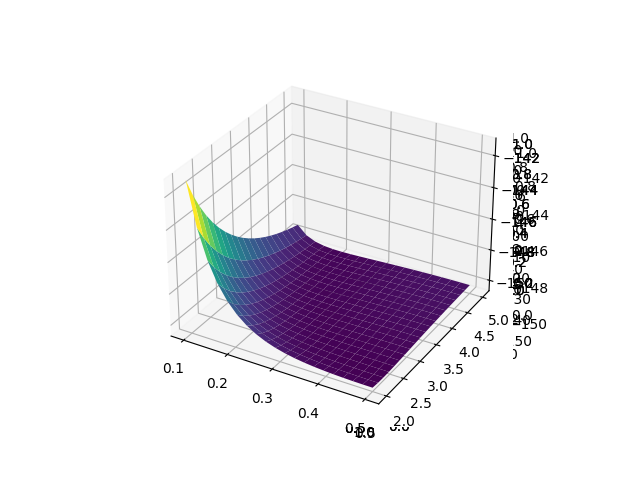

In [150]:
%matplotlib ipympl

x = deltas
y = oo_distances

X, Y = np.meshgrid(x, y)
Z = np.array([e for e in energies.values()])

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
# 3d plot the surface
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis')
plt.show()


# Similar plot, but weith normalized values to see the double well.

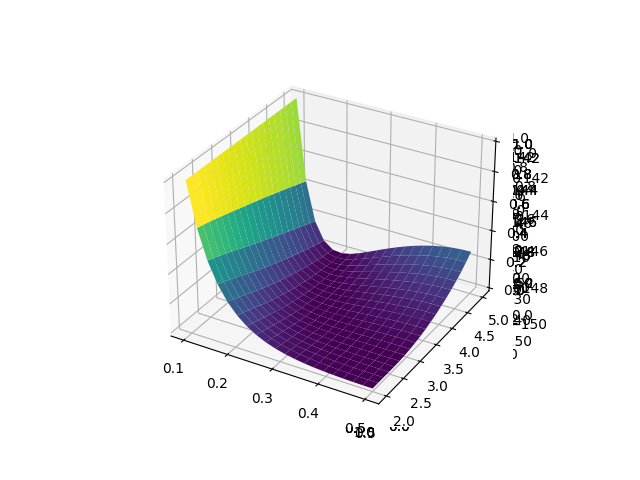

In [151]:
%matplotlib ipympl

x = deltas
y = oo_distances

X, Y = np.meshgrid(x, y)
Z = np.array([(e-np.min(e))/(np.max(e)-np.min(e)) for e in energies.values()])

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
# 3d plot the surface
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis')
plt.show()

# Where does the behaviour change from a double well to a single well?

In [149]:
for d, e in energies.items():
    print(d)
    print(np.all(np.array(e)[1:]-np.array(e)[:-1] < 0))

2.0
True
2.1578947368421053
True
2.3157894736842106
True
2.473684210526316
True
2.6315789473684212
False
2.7894736842105265
False
2.9473684210526314
False
3.1052631578947367
False
3.263157894736842
False
3.4210526315789473
False
3.5789473684210527
False
3.7368421052631575
False
3.894736842105263
False
4.052631578947368
False
4.2105263157894735
False
4.368421052631579
False
4.526315789473684
False
4.684210526315789
False
4.842105263157895
False
5.0
False
